## Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import Pool
from catboost import CatBoostRegressor

Определим константные значения, которые будут использоваться при создании признаков.

In [2]:
# Количество отстающих значений
MAX_LAG = 3

# Размер окна для скользящего среднего
ROLLING_MEAN_SIZE = 4

# Параметр рандомизации
RAND_SEED = 12345

Прочитаем данные из файла и выведем первые 5 строк.

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv')
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Мы видим, что колонка `datetime`, это время. Также стоит заметить, что мы будем работать с временными рядами. Поэтому, еще раз считаем данные из файла, но уже сразу укажем, какую колонку возьмем для индекса. А также преобразуем эту колонку в тип datetime64.

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Можно заметить, что сейчс интервал нашего временного ряда равен 10 минутам.

Выведем информацию о таблице.

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас в таблице единственная колонка с числом заказов - `num_orders`. Сразу проверим, нет лишних пробелов в названии колонки.

In [6]:
taxi.columns

Index(['num_orders'], dtype='object')

Лишних пробелов в названии нет. Теперь посмотрим, есть ли пропуски в данных.

In [7]:
taxi.isnull().sum()

num_orders    0
dtype: int64

Пропусков также нет. После того как мы выделили время в индекс, стоит также проверить, что время расположено в хронологическом порядке.

In [8]:
taxi.index.is_monotonic

True

Данные расположены в хронологическом порядке. Можно продолжить подготавливать данные для анализа.

Проведем ресемплирование по одному часу. Для агрегации значений возьмем суммарное значение заказов в течение этого времени. Сохраним новую таблицу в переменную taxi_h (указание, что данные ресемплированы по часам).

In [9]:
taxi_h = taxi.resample('1H').sum()
taxi_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
taxi_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод

На данном шаге мы прочитали данные из файла. Определили, что это временной ряд, поэтому выделили время в индекс и сразу перевели в соответствующий тип данных. Проверили колонку с числом заказов на наличие пропусков, а также что название колонки не содержит лишних пробелов. Посмотрели, что время расположено в хронологическом порядке. Далее мы изменили временной интревал до 1 часа, в качестве агрегирующего значения взяли сумму заказов за это время.

## 2. Анализ

В первую очередь посомтрим на тренд и сезонность. Получим их с помощью стандартной функции **seasonal_decompose()**.

In [11]:
decomposed = seasonal_decompose(taxi_h)

Выведкем их графики. Остатки рассматривать не будем, в данном случае у нас нет информации, чтобы как-то их проанализировать.

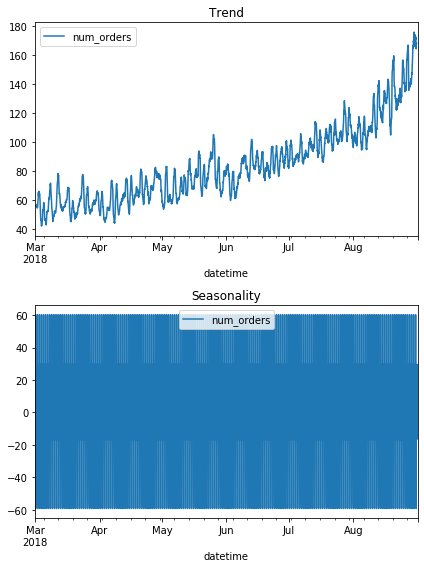

In [12]:
plt.figure(figsize=(6, 8))

plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Из графиков видно, что у есть тренд к повышению числа заказов в течение года (с марта по август). Скорее всего сервис становится популярнее, все больше людей начинают им пользоваться. Про тренд также можно сказать что ряд нестационарный - со временем меняется среднее значение.<br>
Сезонность имеет период много меньше месяца. Необходимо изучить ее более детально.

Выделим данные за март. И еще раз посмотри мна сезонность в течение это периода.

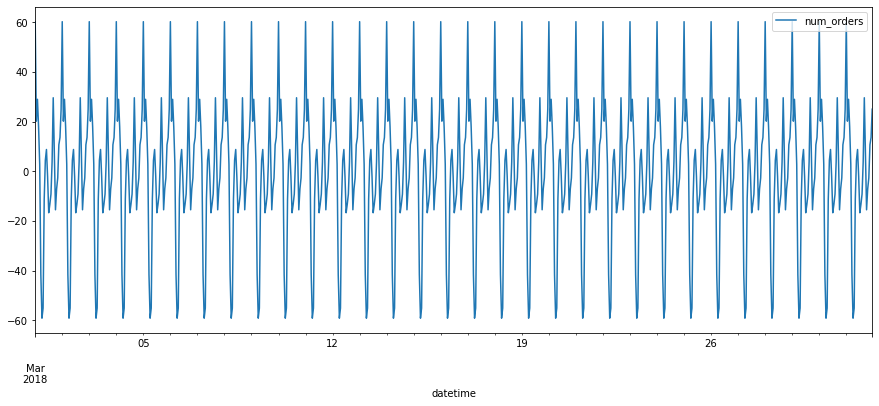

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize=(15, 6))

Необходимо изучить еще более детально данную характеристику. Как видно, период измений 1 день, на нем в дальнейшем подробнее и посмотрим.<br>
Но уже сейчас можно сказать, что временной ряд стационарный - среднее значение не менятся с временем, также как и стандартное отклонение.

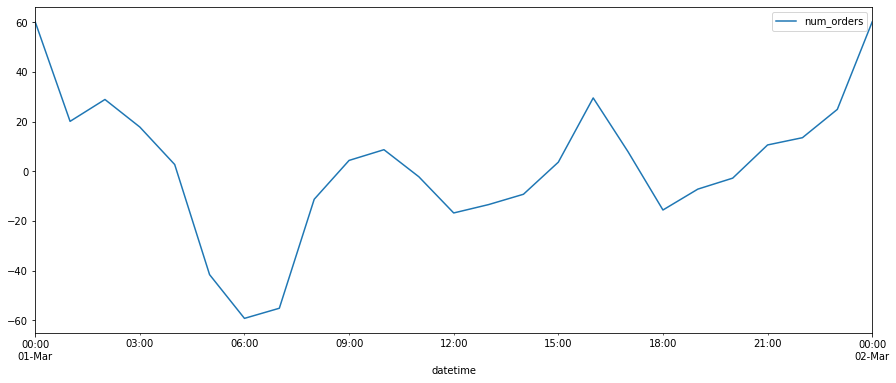

In [14]:
decomposed.seasonal['2018-03-01 00':'2018-03-02 00'].plot(figsize=(15, 6))

Теперь видно, что в течение ночи количество заказов падает, люди в основном спят. Далее, начиная с 6:00, количество заказов растет - люди едут по делам. После, примерно с 9:00 - 17:00 заказы чуть проседают, люди в основной массе находятся на работе и учебе. После этого новый пик - все едут по личным делам. И, после нахождения там, в конце все возвращаются домой. Отдельно стоит отметить, что максимальный пик наступает ночью - в 0:00. Наилучшее время для таксистов.

Мы посомотрели на тренды и сезонность. Теперь подготовим признаки для обучения модели, с помощью которой в дальнейшем будем предсказывать количество заказов в следующий час.

Создадим функцию для создания признаков для горизонта предсказаний в один шаг.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_modified = data.copy()
    
    data_modified['month'] = data_modified.index.month
    data_modified['day'] = data_modified.index.day
    data_modified['hour'] = data_modified.index.hour
    
    for lag in range(1, max_lag + 1):
        data_modified['lag_{}'.format(lag)] = data_modified['num_orders'].shift(lag)
    
    data_modified['rolling_mean'] = data_modified['num_orders'].rolling(rolling_mean_size).mean().shift()
    
    return data_modified

Параметры для функции определены ранее как константы. Количество отстающих значений возьмем равное 3, а размер скользящего окна 4.

In [16]:
taxi_h_m = make_features(taxi_h, MAX_LAG, ROLLING_MEAN_SIZE)
print(taxi_h_m.head())

                     num_orders  month  day  hour  lag_1  lag_2  lag_3  \
datetime                                                                 
2018-03-01 00:00:00         124      3    1     0    NaN    NaN    NaN   
2018-03-01 01:00:00          85      3    1     1  124.0    NaN    NaN   
2018-03-01 02:00:00          71      3    1     2   85.0  124.0    NaN   
2018-03-01 03:00:00          66      3    1     3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1     4   66.0   71.0   85.0   

                     rolling_mean  
datetime                           
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00           NaN  
2018-03-01 03:00:00           NaN  
2018-03-01 04:00:00          86.5  


На основе полученной таблицы получим обучающую и тестовую выборки. При этом укажем, что не нужно перетасовывать строки. На тестовую выброку выделим 10% от исходных данных. Сразу будем оценивать результаты на тестовой сборке. Так как для временных рядов, чем больше данных для обучения, тем лучше. И если выделить валидационную выборку для оценки, модель обучать на тренировочной, и после этого проверять работу на тестовой, то качество на валидационной будет выше, чем на тестовой. Мы хотим предсказать количество заказов на 1 час вперед, а не в каких-то случайных момент в будущем.

In [17]:
train, test = train_test_split(taxi_h_m, shuffle=False, test_size=0.1)

Удалим строки с пропущенными значениями, которые появились при формировании признаков.

In [18]:
train = train.dropna()

Выделим признаки для обучения и целевой признак.

In [19]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

На данный момент, все колонки для признаков хранят числовые значения. Категориальных переменных нет. Однако, необходимо масштабировать наши количественные признаки путем стандартизации.

In [20]:
num_features = ['month', 'day', 'hour', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']

In [21]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

Проверим резальтат для обучающей выборки.

In [22]:
features_train.head()

,month,day,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,
2018-03-01 04:00:00,-1.413472,-1.593142,-1.083255,-0.317243,-0.187822,0.174631,0.277957
2018-03-01 05:00:00,-1.413472,-1.593142,-0.938675,-0.911959,-0.317110,-0.187505,-0.404765
2018-03-01 06:00:00,-1.413472,-1.593142,-0.794096,-1.868677,-0.911833,-0.316840,-1.070630
2018-03-01 07:00:00,-1.413472,-1.593142,-0.649516,-1.713534,-1.868562,-0.911777,-1.567922
2018-03-01 08:00:00,-1.413472,-1.593142,-0.504936,-1.635962,-1.713416,-1.868850,-1.997785


### Вывод

На данном шаге мы провели анализ данных. Посмотрели на тренды и сезонность временного ряда. Выснили что количество заказов в течение месяцев растет. Также посмотрели как распределяются заказы в течение одного дня. Далее выделили дополнительные признаки и выделили целевой признак. Разделили первоначальные данные на обучающую и тестовую выборки. Можно переходить к обучению и подбору наилучшей модели.

## 3. Обучение

Обучим три разные модели на нашей тренировочной выборке. А затем выберем лучшую модель, путем оценки ее работы на тестовой выборке.

### 3.1 Линейная регрессия

Рассмотрим модель линейной регрессии.

In [23]:
model_lr = LinearRegression()

In [24]:
model_lr.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 3.2 CatBoost

Вторая модель, которую мы посмотрим, будет модель на основе градиентного бустинга из библиотеки CatBoost.

In [25]:
model_cbr = CatBoostRegressor(loss_function='RMSE')

Переберем несколько гиперпараметров с помощью поиска по сетке.

In [26]:
grid_cbr = {'iterations': [1000, 2000],
            'learning_rate': [0.01, 0.1]}

In [27]:
train_pool = Pool(data=features_train, label=target_train)

In [28]:
tscv_cbr = TimeSeriesSplit(n_splits=5)

In [29]:
result = model_cbr.grid_search(param_grid=grid_cbr, X=train_pool, cv=tscv_cbr)

0:	loss: 33.5557997	best: 33.5557997 (0)	total: 29s	remaining: 1m 27s
1:	loss: 34.8166578	best: 33.5557997 (0)	total: 57.8s	remaining: 57.8s
2:	loss: 32.9570733	best: 32.9570733 (2)	total: 1m 57s	remaining: 39.1s
3:	loss: 34.8166578	best: 32.9570733 (2)	total: 2m 54s	remaining: 0us
Estimating final quality...


In [30]:
model_cbr.get_params()

{'loss_function': 'RMSE', 'iterations': 2000, 'learning_rate': 0.01}

### 3.3 Случайный лес

Также рассмотрим еще одну ансамблевую модель - случайный лес. Также переберем несколько разных гиперпараметров с помощью поиска по сетке.

In [31]:
model_rfr = RandomForestRegressor(random_state=RAND_SEED)

In [32]:
grid_rfr = {'n_estimators': [1000, 2000],
            'max_depth': [10, 20]}

In [33]:
tscv_rfr = TimeSeriesSplit(n_splits=5)

In [34]:
model_grid_rfr = GridSearchCV(estimator=model_rfr, 
                              param_grid=grid_rfr, 
                              cv=tscv_rfr, 
                              scoring='neg_mean_squared_error', 
                              verbose=5)
model_grid_rfr.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=10, n_estimators=1000 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. max_depth=10, n_estimators=1000, score=-567.619, total=   4.8s
[CV] max_depth=10, n_estimators=1000 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] .. max_depth=10, n_estimators=1000, score=-527.596, total=   7.4s
[CV] max_depth=10, n_estimators=1000 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] .. max_depth=10, n_estimators=1000, score=-600.964, total=  10.0s
[CV] max_depth=10, n_estimators=1000 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s


[CV] .. max_depth=10, n_estimators=1000, score=-652.241, total=  12.0s
[CV] max_depth=10, n_estimators=1000 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.2s remaining:    0.0s


[CV] . max_depth=10, n_estimators=1000, score=-1037.466, total=  12.4s
[CV] max_depth=10, n_estimators=2000 .................................
[CV] .. max_depth=10, n_estimators=2000, score=-565.022, total=   5.9s
[CV] max_depth=10, n_estimators=2000 .................................
[CV] .. max_depth=10, n_estimators=2000, score=-530.711, total=   9.1s
[CV] max_depth=10, n_estimators=2000 .................................
[CV] .. max_depth=10, n_estimators=2000, score=-600.728, total=  12.3s
[CV] max_depth=10, n_estimators=2000 .................................
[CV] .. max_depth=10, n_estimators=2000, score=-649.494, total=  15.6s
[CV] max_depth=10, n_estimators=2000 .................................
[CV] . max_depth=10, n_estimators=2000, score=-1040.674, total=  19.2s
[CV] max_depth=20, n_estimators=1000 .................................
[CV] .. max_depth=20, n_estimators=1000, score=-569.597, total=   3.4s
[CV] max_depth=20, n_estimators=1000 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

In [35]:
best_rfr_depth = model_grid_rfr.best_params_['max_depth']
best_rfr_estimators = model_grid_rfr.best_params_['n_estimators']

Мы нашли наилучшие гиперпараметры. В качестве функции потерь в данном случае мы взяли значение MSE. Это значение это квадрат RMSE, так что модель с лучших MSE, это и модель с лучшим RMSE.

In [36]:
model_rfr_best = RandomForestRegressor(n_estimators=best_rfr_estimators, max_depth=best_rfr_depth, random_state=RAND_SEED)

In [37]:
model_rfr_best.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

### Вывод

На данном этапе мы обучили три разных модели с различными гиперпараметрами. При поиске по сетке, мы оценивали качество моделей с помощью метрик RMSE и MSE (что соответствует оwенке по RMSE). Теперь можно проверить качестов работы на тестовой выборке.

## 4. Тестирование

### 4.1 Линейная регрессия

In [38]:
predictions_lr = model_lr.predict(features_test)

In [39]:
# посчитаем значение RMSE (квадратный корень из средней квадратичной ошибки) через вычисление MSE
mse_lr = mean_squared_error(target_test, predictions_lr)
rmse_lr = mse_lr ** 0.5
print('rmse_lr =', rmse_lr)

rmse_lr = 52.56894910111406


### 4.2 CatBoost

In [40]:
predictions_cbr = model_cbr.predict(features_test)

In [41]:
# посчитаем значение RMSE (квадратный корень из средней квадратичной ошибки) через вычисление MSE
mse_cbr = mean_squared_error(target_test, predictions_cbr)
rmse_cbr = mse_cbr ** 0.5
print('rmse_cbr =', rmse_cbr)

rmse_cbr = 45.93679852189139


### 4.3 Случайный лес

In [42]:
predictions_rfr = model_rfr_best.predict(features_test)

In [43]:
# посчитаем значение RMSE (квадратный корень из средней квадратичной ошибки) через вычисление MSE
mse_rfr = mean_squared_error(target_test, predictions_rfr)
rmse_rfr = mse_rfr ** 0.5
print('rmse_rfr =', rmse_rfr)

rmse_rfr = 46.6928701276678


### Вывод

На данном этапе, мы проверили обученные модели на тестовой выборке. Качество оценивали с помощью метрики RMSE.<br> 
- Линейная регрессия: &emsp; 52.56895
- CatBoost: &emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 45.93680
- Случайный лес: &emsp;&emsp;&emsp;&nbsp; 46.69287

Лучшая модель по данному критерию является CatBoost. Данное значение меньше 48, что удовлетворяет предъявляемым требованиям.

## 5. Общий вывод

В данной проекте мы работали с временными рядами: у нас были исторические данные количества заказов такси в определенное время. по итогу мы научились прогнозировать количество заказов такси на следующий час.<br> 
Изначально мы подготовили данные: выкачали их из фалйа, сразу определили где хранится время и выделили эту колонку в индекс. Далее мы ресеплировали наши данные по одному часу. После мы посмотрели на тренды и сезонность получившего временного ряда - как развивается служба такси в течение года и какие типичное распределение заказов в течение дня. После чего, выделили необходимые признаки, которые понядобятся для обучение модели. Далее мы выбрали разные модели и обучили их, предварительно перебрав различные гиперпараметры и выбрав наилучшие из них. В итоге мы проверили качество получившихся моделей на тестовой выборке. Лучшей моделью в нашем проекте стала CatBoost, по оценке качества метрикой RMSE (45.93680).